## 1. Libraries 📖

In [13]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [14]:
df_train = pd.read_csv("../../data/train/cardio/cardio_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_pubchem_valid.csv")

In [15]:
df_train_all = pd.concat([df_train, df_valid])

In [16]:
X_train = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train = df_train_all['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

In [17]:
X_train.shape, y_train.shape

((8505, 881), (8505,))

In [18]:
X_test.shape, y_test.shape

((2127, 881), (2127,))

## 3. Remove low variance features

In [19]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,...,PubchemFP824,PubchemFP826,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP836,PubchemFP839,PubchemFP842,PubchemFP860,PubchemFP863
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1059,0,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1060,1,1,1,0,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1061,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_test

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,...,PubchemFP824,PubchemFP826,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP836,PubchemFP839,PubchemFP842,PubchemFP860,PubchemFP863
0,1,1,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,1,1,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2123,1,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2124,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2125,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# write

with open('../../pubchem_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['cardio'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [22]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [23]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 50, 'solver': 'svd', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 0.6409828583468609
MSE: 0.7633239757841891
RMSE: 0.8736841395974801
R2 Square 0.1475318309379393 

Base model:
MAE: 0.6408672326252111
MSE: 0.7644402752066195
RMSE: 0.8743227523098204
R2 Square 0.14628516536086678 

Train set:
Tuned model:
MAE: 0.6270094038431139
MSE: 0.7326335442182463
RMSE: 0.8559401522409417
R2 Square 0.19322783522185916 

Base model:
MAE: 0.629424982067786
MSE: 0.7408755625189807
RMSE: 0.860741286635526
R2 Square 0.1841517684773044 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [19]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [500, 1000, 2000, 3000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 10, 'n_estimators': 3000} 

Test set:
Tuned model:
MAE: 0.585291556127422
MSE: 0.6531467752473732
RMSE: 0.8081749657390862
R2 Square 0.2705759896354477 

Base model:
MAE: 0.5702414271278159
MSE: 0.6379096673044657
RMSE: 0.7986924735494042
R2 Square 0.2875925513077666 

Train set:
Tuned model:
MAE: 0.5158045648960315
MSE: 0.4825570504663627
RMSE: 0.6946632640829388
R2 Square 0.468610740927625 

Base model:
MAE: 0.43913786919411746
MSE: 0.3612599081984464
RMSE: 0.6010490064865314
R2 Square 0.6021825092709776 



In [24]:
params = {'max_depth': 10, 'n_estimators': 3000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train) 

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.585291556127422
MSE: 0.6531467752473732
RMSE: 0.8081749657390862
R2 Square 0.2705759896354477 

Train set:
MAE: 0.5158045648960315
MSE: 0.4825570504663627
RMSE: 0.6946632640829388
R2 Square 0.468610740927625 



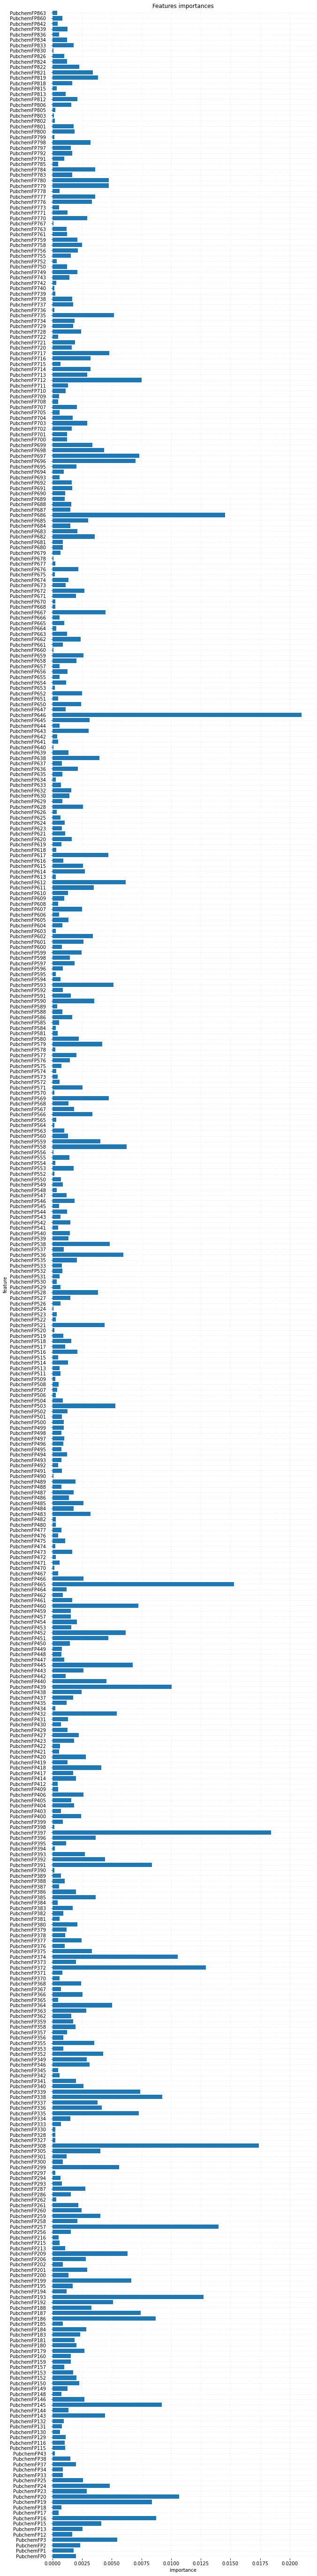

In [21]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [13]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [27]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [80, 95, 120, 150],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.5652675605547506
MSE: 0.6405446576555257
RMSE: 0.8003403386407096
R2 Square 0.2846498356702071 

Base model:
MAE: 0.5871539472210996
MSE: 0.6811356947885939
RMSE: 0.8253094539556626
R2 Square 0.23931840602448107 

Train set:
Tuned model:
MAE: 0.459407758696141
MSE: 0.4248082024301409
RMSE: 0.6517731218991321
R2 Square 0.532203465436766 

Base model:
MAE: 0.4364837749397062
MSE: 0.37444531936030806
RMSE: 0.6119193732513362
R2 Square 0.5876628045830141 



In [14]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.5652675605547506
MSE: 0.6405446576555257
RMSE: 0.8003403386407096
R2 Square 0.2846498356702071 

Train set:
MAE: 0.459407758696141
MSE: 0.4248082024301409
RMSE: 0.6517731218991321
R2 Square 0.532203465436766 



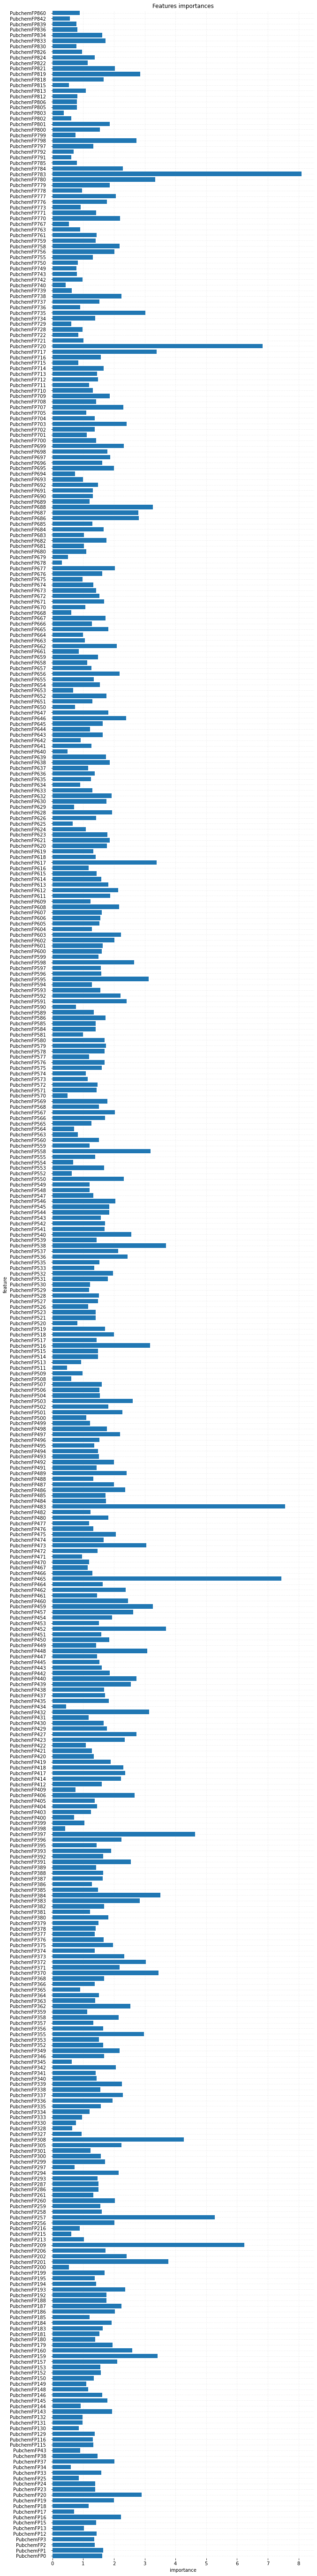

In [29]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650


## 5.4. LightGBM

Better results - third model.

In [36]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000],
    'min_child_samples': [30, 55, 65, 85],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.5717884663222127
MSE: 0.6446584166904064
RMSE: 0.8029062315678004
R2 Square 0.2800556545050936 

Base model:
MAE: 0.5789910638683837
MSE: 0.6564025345241197
RMSE: 0.8101867281831514
R2 Square 0.2669400090589126 

Train set:
Tuned model:
MAE: 0.495031281392012
MSE: 0.479871895867776
RMSE: 0.6927278656642708
R2 Square 0.47156761889937726 

Base model:
MAE: 0.4998340358512988
MSE: 0.4808571908410797
RMSE: 0.6934386712904608
R2 Square 0.4704826173118436 



In [16]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.5716194283357794
MSE: 0.6447736520560696
RMSE: 0.8029779897706223
R2 Square 0.2799269614674129 

Train set:
MAE: 0.49603317356284127
MSE: 0.48135189046194304
RMSE: 0.693795279936339
R2 Square 0.4699378567187906 



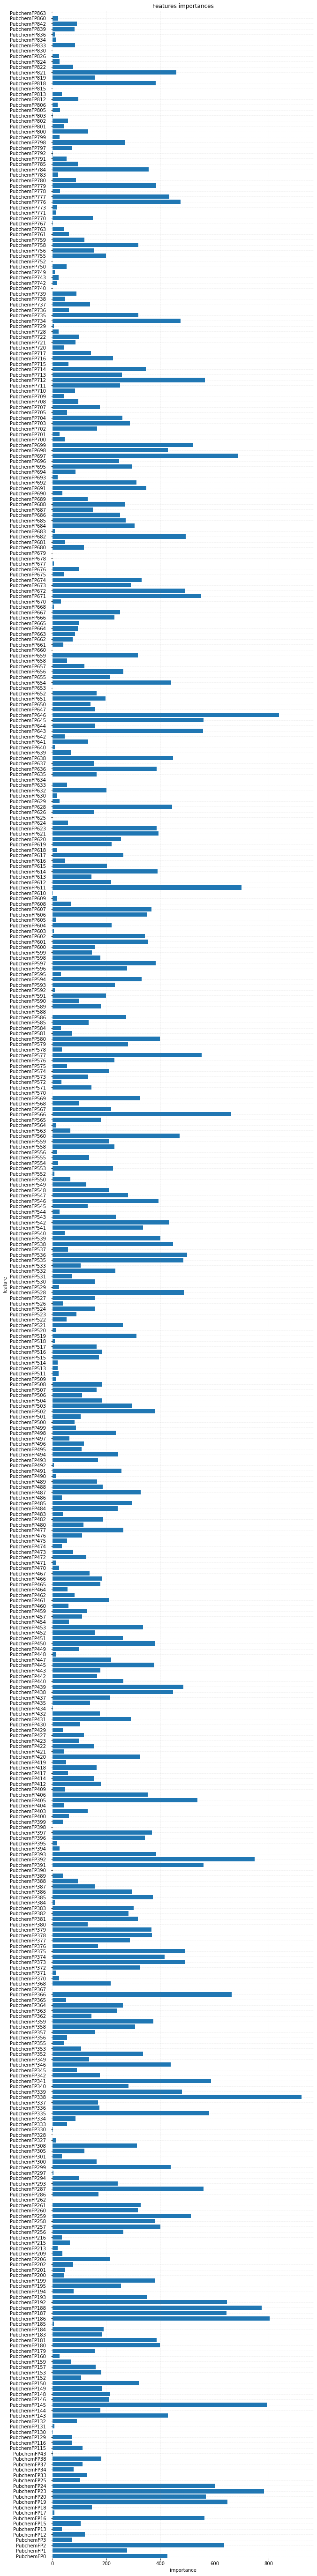

In [38]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [17]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [18]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 5, 10, 20],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20, 25],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 0.5761954797158507
MSE: 0.647347624473517
RMSE: 0.8045791598553352
R2 Square 0.2770523896951017 

Base model:
MAE: 0.5789910654886605
MSE: 0.6564025343733105
RMSE: 0.8101867280900809
R2 Square 0.26694000922733385 

Train set:
Tuned model:
MAE: 0.4980256897872225
MSE: 0.4702632961095799
RMSE: 0.6857574615777651
R2 Square 0.4821485578811957 

Base model:
MAE: 0.49983403745441235
MSE: 0.4808571914221361
RMSE: 0.6934386717094282
R2 Square 0.47048261667198743 



In [19]:
params = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.5761954797158507
MSE: 0.647347624473517
RMSE: 0.8045791598553352
R2 Square 0.2770523896951017 

Train set:
MAE: 0.4980256897872225
MSE: 0.4702632961095799
RMSE: 0.6857574615777651
R2 Square 0.4821485578811957 



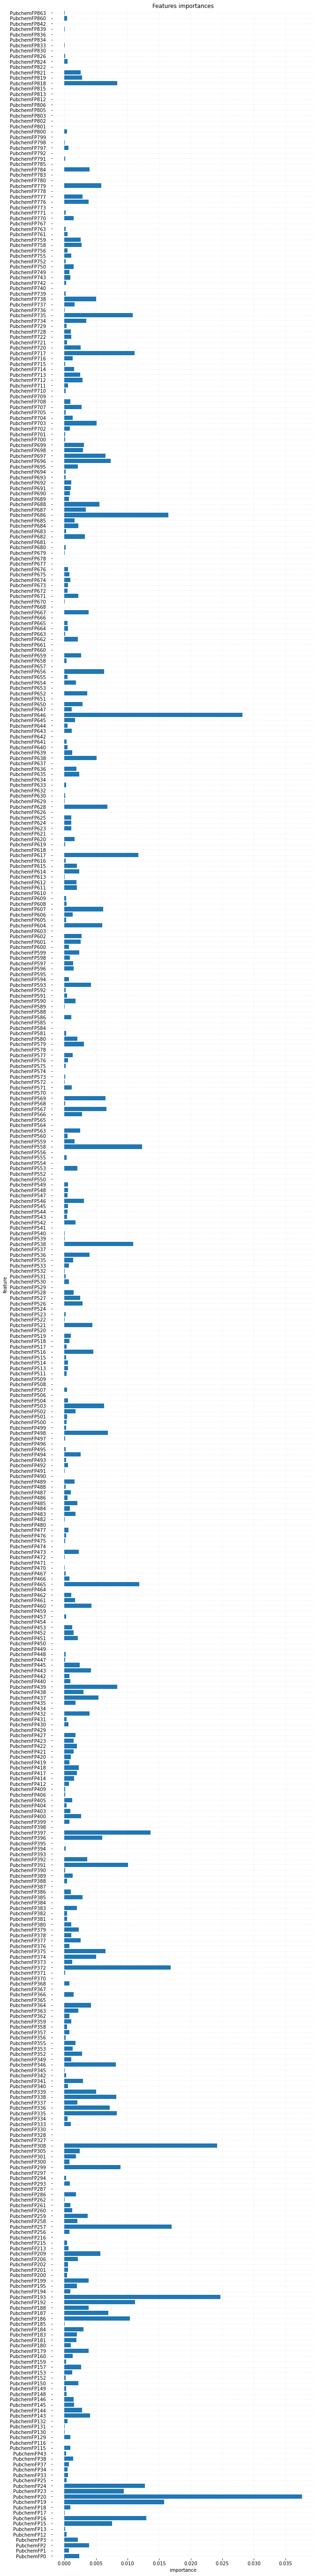

In [20]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927
4,HistGradient Boosting Regressor,0.576195,0.647348,0.804579,0.277052


## 5.6. Support Vector Regression

Better results - fifth model.

In [28]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1, 2.5, 3],
    'epsilon': [0.3, 0.5, 1, 2],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 2.5, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.5726675039536304
MSE: 0.6657065733592209
RMSE: 0.8159084344209349
R2 Square 0.2565494053280488 

Base model:
MAE: 0.5675345049457087
MSE: 0.6859162168605952
RMSE: 0.8282005897490023
R2 Square 0.2339795944226406 

Train set:
Tuned model:
MAE: 0.46122665049407174
MSE: 0.4673931909114451
RMSE: 0.6836616055560273
R2 Square 0.4853091024701156 

Base model:
MAE: 0.48081984136711176
MSE: 0.566353466452832
RMSE: 0.7525645928774699
R2 Square 0.3763345730404575 



In [29]:
params = {'C': 2.5, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.5726675039536304
MSE: 0.6657065733592209
RMSE: 0.8159084344209349
R2 Square 0.2565494053280488 

Train set:
MAE: 0.46122665049407174
MSE: 0.4673931909114451
RMSE: 0.6836616055560273
R2 Square 0.4853091024701156 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [30]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927
4,HistGradient Boosting Regressor,0.576195,0.647348,0.804579,0.277052
5,Support Vector Regression,0.572668,0.665707,0.815908,0.256549


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [31]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.20 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.5660672446408345
MSE: 0.6352400487051394
RMSE: 0.7970194782470121
R2 Square 0.2905739392264728 

Train set:
MAE: 0.4790749412676072
MSE: 0.4494412500317454
RMSE: 0.6704037962539782
R2 Square 0.5050776843481659 



In [32]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927
4,HistGradient Boosting Regressor,0.576195,0.647348,0.804579,0.277052
5,Support Vector Regression,0.572668,0.665707,0.815908,0.256549
6,Averaging base models,0.566067,0.635240,0.797019,0.290574


### Averaging base models with Meta-model

In [33]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [34]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.277067,5.176354,5.207794,5.163345,5.299842
1,5.122860,5.007533,5.048551,5.047223,4.973846
2,4.908423,4.636930,4.753225,4.664611,4.564357
3,7.178747,6.717039,6.690764,6.953610,6.963570
4,5.272590,5.445476,5.556119,5.120833,5.440571
...,...,...,...,...,...
8500,5.100939,5.270157,5.378010,5.201317,5.186454
8501,5.285235,5.089201,5.219362,5.077389,5.300018
8502,4.819235,4.745040,4.791786,4.714525,5.107940
8503,4.970111,5.053375,4.990386,5.053231,4.859960


In [35]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.5818900121421267
MSE: 0.6993649692847902
RMSE: 0.8362804369855785
R2 Square 0.21896023996905556 

Train set:
MAE: 0.39757543204106804
MSE: 0.33019241872474214
RMSE: 0.5746237192500342
R2 Square 0.6363938635486026 



In [36]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927
4,HistGradient Boosting Regressor,0.576195,0.647348,0.804579,0.277052
5,Support Vector Regression,0.572668,0.665707,0.815908,0.256549
6,Averaging base models,0.566067,0.635240,0.797019,0.290574
7,Base models + Meta-model,0.581890,0.699365,0.836280,0.218960


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [37]:
params_rf = {'max_depth': 10, 'n_estimators': 3000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10}    

params_svr = {'C': 2.5, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'} 

In [38]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.609284109979951
Model1 R2: 0.2837285133718266
Model2 MSE: 0.5773257679349835
Model2 R2: 0.3212985874830221
Model3 MSE: 0.5899723613592739
Model3 R2: 0.3064313127183861
Model4 MSE: 0.5924172824612072
Model4 R2: 0.30355707516042973
Model5 MSE: 0.5994183107553273
Model5 R2: 0.2953266997706625
Average MSE = 0.5936835664981486
Average R2 = 0.3020684377008654
-------------- fold 2 --------------
Model1 MSE: 0.6859420111805887
Model1 R2: 0.2652964342786003
Model2 MSE: 0.6659306286101654
Model2 R2: 0.28673036584987177
Model3 MSE: 0.6688750312974963
Model3 R2: 0.28357665443106184
Model4 MSE: 0.6626103715558381
Model4 R2: 0.2902866499922111
Model5 MSE: 0.6941170356045044
Model5 R2: 0.2565402719555302
Average MSE = 0.6754950156497186
Average R2 = 0.2764860753014551
-------------- fold 3 --------------
Model1 MSE: 0.6833155955614615
Model1 R2: 0.2789079099150956
Model2 MSE: 0.6730573726357639
Model2 R2: 0.2897332495650272
Model3 MSE: 0.67291739828

In [39]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [40]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [41]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.325873,5.338926,5.305731,5.400402,5.438888
1,5.169386,5.110243,5.144887,5.201721,5.132594
2,4.970766,4.740975,4.816090,4.939972,4.613012
3,6.754866,6.379301,6.357160,6.130626,6.590827
4,5.525690,5.818353,5.971390,5.899149,5.648743
...,...,...,...,...,...
8500,5.144405,5.330272,5.478631,5.162680,5.066235
8501,5.227059,5.046723,5.114998,5.156136,5.298063
8502,4.693046,4.778594,4.770365,4.619624,5.086728
8503,4.937633,5.015103,5.009694,5.072347,4.767463


In [42]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.119576,5.220317,5.137737,5.172455,5.051101
1,5.192322,5.154516,5.212735,5.227572,5.240101
2,5.171567,5.517956,5.446392,5.393417,5.375905
3,5.600105,5.676575,5.737012,5.628331,5.774117
4,4.954202,4.547495,4.607894,4.954471,4.590939
...,...,...,...,...,...
2122,5.168975,5.257836,5.268540,5.179987,5.169047
2123,5.030874,4.947262,4.917084,4.892361,4.895271
2124,5.313915,5.984648,5.761929,6.046769,5.440369
2125,4.835314,4.669982,4.690149,4.830157,4.768385


In [43]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.5660224890472076
MSE: 0.6358970249113848
RMSE: 0.7974315173802605
R2 Square 0.28984023856800745 

Train set:
MAE: 0.5808766042828599
MSE: 0.6580922335183369
RMSE: 0.811228841646016
R2 Square 0.2753123303604701 



In [44]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.640983,0.763324,0.873684,0.147532
1,Random Forest Regressor,0.585292,0.653147,0.808175,0.270576
2,XGBoost,0.565268,0.640545,0.800340,0.284650
3,LightGBM,0.571619,0.644774,0.802978,0.279927
4,HistGradient Boosting Regressor,0.576195,0.647348,0.804579,0.277052
5,Support Vector Regression,0.572668,0.665707,0.815908,0.256549
6,Averaging base models,0.566067,0.635240,0.797019,0.290574
7,Base models + Meta-model,0.581890,0.699365,0.836280,0.218960
8,Base models + Meta-model + cv,0.566022,0.635897,0.797432,0.289840
